In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LinearRegression, ElasticNetCV, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
import matplotlib.pyplot as plt
from pathlib import Path
import warnings # to silence convergence warnings

Load the data

In [3]:
df = pd.read_csv('Data/case1Data.csv')

#Missing Data Nan values, replace with mean or median
df = df.fillna(df.mean())

#Split data into X and Y
Y = df['y']
X = df.drop(columns=['y'])

#Convert to NumPy arrays
X = X.to_numpy()      
Y = Y.to_numpy()      



print("X shape:", X.shape)
print("y shape:", Y.shape)

X shape: (100, 100)
y shape: (100,)


In [4]:
def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu

def normalize(X):
    '''
    Function for normalizing the columns (variables) of a data matrix to unit length.
    Returns the normalized data and the L2 norm of the variables 
    
    Input  (X) --------> The data matrix to be normalized 
    Output (X_pre)-----> The normalized data matrix 
    Output (d) --------> Array with the L2 norms of the variables 
    '''
    d = np.linalg.norm(X,axis=0,ord=2)  # d is the euclidian lenghts of the variables 
    d[d==0]=1                           # Avoid dividing by zero if column L2 norm is zero 
    X_pre = X / d                       # Normalize the data with the euclidian lengths
    return X_pre,d                      # Return normalized data and the euclidian lengths



Split and Normalize the data 

In [5]:
#Center data
X, mu = centerData(X)
#Normalize data
X, d = normalize(X)
#Center Y
Y, mu_y = centerData(Y)

alphas = np.logspace(-3, 1, num=20)

# X, Y are numeric and you want to do regression
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1312)

Linear Regression

In [6]:
#OLS Regression
model = LinearRegression()

# Train model
model.fit(X_train, Y_train)

# Evaluate model (R^2 by default for .score with regressors)
score = model.score(X_test, Y_test)
print('OLS Regression R^2 Score:', score)

error = np.mean((model.predict(X_test) - Y_test) ** 2)
print('Mean Squared Error:', error)

OLS Regression R^2 Score: 0.6134004289921104
Mean Squared Error: 1623.8331582513663


Ridge regression

Mean Squared Error: 1068.2218618255224 Alpha: 0.5455594781168515
R^2: 0.7456794674843876


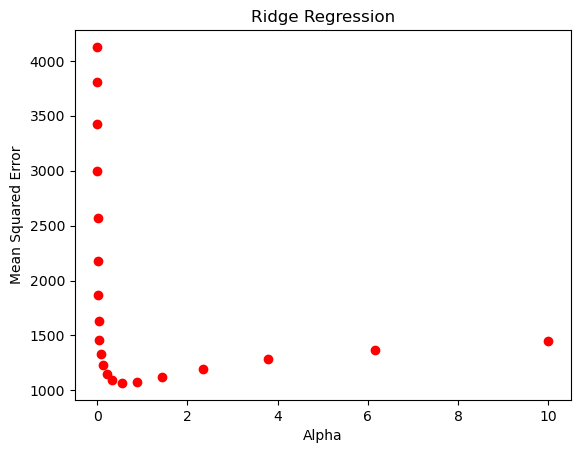

In [7]:
#Ridge Regression

error = np.array([])
score = np.array([])
for alpha in alphas:
    # Create a Ridge model
    model = Ridge(alpha=alpha)

    # Train model
    model.fit(X_train, Y_train)

    # Evaluate model (R^2 by default for .score with regressors)
    score = np.append(np.array(model.score(X_test, Y_test)),score)

    error = np.append(np.array(np.mean((model.predict(X_test) - Y_test) ** 2)),error)


plt.plot(alphas, error, 'ro')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Ridge Regression')

print('Mean Squared Error:', min(error), 'Alpha:', alphas[np.argmin(error)])
print('R^2:', score[np.argmin(error)])

Mean Squared Error: 594.008990646221 Alpha: 0.07847599703514611
R^2: 0.8585793005939406


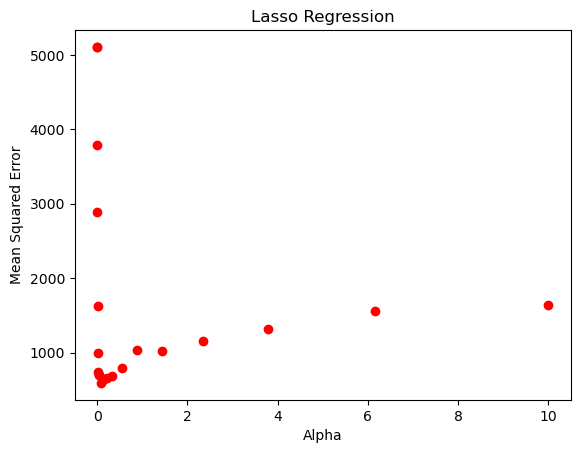

In [8]:
#Lasso Regression

error = np.array([])
score = np.array([])
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for alpha in alphas:
        # Create a Lasso model
        model = Lasso(alpha=alpha)

        # Train model
        model.fit(X_train, Y_train)

        # Evaluate model (R^2 by default for .score with regressors)
        score = np.append(np.array(model.score(X_test, Y_test)),score)

        error = np.append(np.array(np.mean((model.predict(X_test) - Y_test) ** 2)),error)


plt.plot(alphas, error, 'ro')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Lasso Regression')

print('Mean Squared Error:', min(error), 'Alpha:', alphas[np.argmin(error)])
print('R^2:', score[np.argmin(error)])

Summary of Results:
l1_ratio: 0.00, R^2 Score: 0.7066, Mean Squared Error: 1232.3983
l1_ratio: 0.11, R^2 Score: 0.7113, Mean Squared Error: 1212.4510
l1_ratio: 0.22, R^2 Score: 0.7170, Mean Squared Error: 1188.8918
l1_ratio: 0.33, R^2 Score: 0.7220, Mean Squared Error: 1167.8046
l1_ratio: 0.44, R^2 Score: 0.7114, Mean Squared Error: 1212.2154
l1_ratio: 0.56, R^2 Score: 0.7200, Mean Squared Error: 1175.9922
l1_ratio: 0.67, R^2 Score: 0.7132, Mean Squared Error: 1204.5756
l1_ratio: 0.78, R^2 Score: 0.7112, Mean Squared Error: 1212.8838
l1_ratio: 0.89, R^2 Score: 0.7213, Mean Squared Error: 1170.5073
l1_ratio: 1.00, R^2 Score: 0.8321, Mean Squared Error: 705.1963

Best Parameters Based on MSE:
l1_ratio: 1.00
alpha: 0.3360
R^2 Score: 0.8321
Mean Squared Error: 705.1963


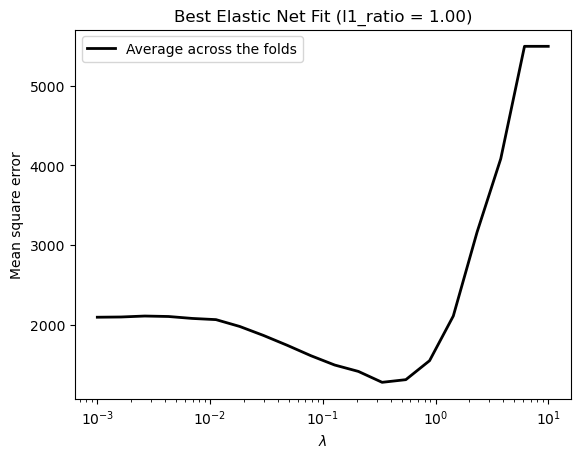

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNetCV
import warnings

# Define ranges for l1_ratio and alpha
l1_ratios = np.linspace(0, 1, num=10)  # Test different L1/L2 penalty ratios
alphas = np.logspace(-3, 1, num=20)       # Range of alpha values

# Store results for analysis
results = []
best_mse = float('inf')  # Initialize best MSE as infinity
best_model = None        # To store the best ElasticNetCV model
best_ratio_l1 = None     # To store the best l1_ratio

with warnings.catch_warnings():  # Suppress convergence warnings
    warnings.simplefilter("ignore")

    for ratio_l1 in l1_ratios:
        # Run ElasticNetCV for each l1_ratio
        model = ElasticNetCV(l1_ratio=ratio_l1, alphas=alphas, cv=5, max_iter=1000)
        model.fit(X_train, Y_train)

        # Evaluate model
        score = model.score(X_test, Y_test)
        error = np.mean((model.predict(X_test) - Y_test) ** 2)

        # Store results
        results.append((ratio_l1, score, error))

        # Check if this is the best MSE so far
        if error < best_mse:
            best_mse = error
            best_model = model
            best_ratio_l1 = ratio_l1

# Print results summary
print("Summary of Results:")
for ratio_l1, score, error in results:
    print(f"l1_ratio: {ratio_l1:.2f}, R^2 Score: {score:.4f}, Mean Squared Error: {error:.4f}")

# Print the best parameters
print("\nBest Parameters Based on MSE:")
print(f"l1_ratio: {best_ratio_l1:.2f}")
print(f"alpha: {best_model.alpha_:.4f}")
print(f"R^2 Score: {best_model.score(X_test, Y_test):.4f}")
print(f"Mean Squared Error: {best_mse:.4f}")

# Plot the MSE path for the best model
plt.figure()
plt.semilogx(best_model.alphas_, best_model.mse_path_.mean(axis=-1), 'k', label='Average across the folds', linewidth=2)
plt.xlabel(r'$\lambda$')
plt.ylabel('Mean square error')
plt.title(f'Best Elastic Net Fit (l1_ratio = {best_ratio_l1:.2f})')
plt.legend()
plt.show()

KNN regression

In [10]:

from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np

# Define the range of neighbors to test
neighbours = np.arange(1, 11, 1)

# Create an instance of KNeighborsRegressor
knn = KNeighborsRegressor()

# Set up GridSearchCV with the parameter grid and scoring based on MSE
model = GridSearchCV(knn, {'n_neighbors': neighbours}, cv=5, scoring='neg_mean_squared_error')

# Train the model
model.fit(X_train, Y_train)

# Get the best parameters and the corresponding MSE
best_params = model.best_params_
best_mse = -model.best_score_  # Convert negative MSE back to positive

print('Best Parameters:', best_params)
print('Best Mean Squared Error (MSE):', best_mse)

# Evaluate the best model on the test set
score = model.score(X_test, Y_test)  # This will still use neg_mean_squared_error
test_mse = mean_squared_error(Y_test, model.predict(X_test))
print('Test Set Mean Squared Error:', test_mse)
print('Test Set R^2 Score:', model.best_estimator_.score(X_test, Y_test))

c:\Users\laans\anaconda3\envs\MLop\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\laans\anaconda3\envs\MLop\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Best Parameters: {'n_neighbors': 10}
Best Mean Squared Error (MSE): 4337.018093070697
Test Set Mean Squared Error: 3967.028960507826
Test Set R^2 Score: 0.055536163604565814


Predicting y_new data using RMSE

In [11]:
X_new = pd.read_csv('./Data/case1Data_Xnew.csv')

#Missing Data Nan values, replace with mean or median
X_new = X_new.fillna(X_new.mean())

#Convert to NumPy arrays
X_new = X_new.to_numpy()

#Center data
X_new = centerData(X_new)[0]
#Normalize data
X_new = normalize(X_new)[0]



KNeighborsRegressor(n_neighbors=10)

Estimated RMSE (RMSE) from Cross-Validation: 65.8560


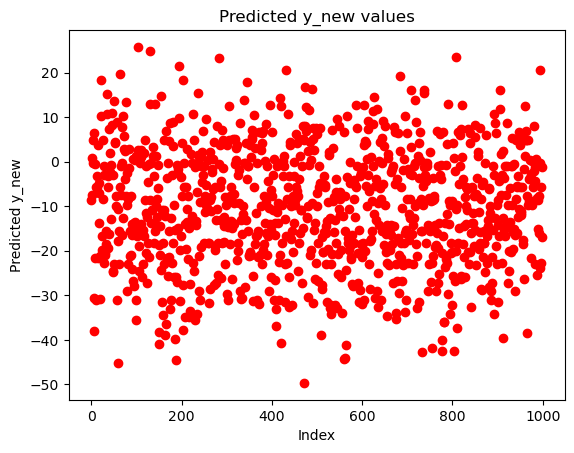

The RMSE estimate (RMSE ˆ) was calculated using 5-fold cross-validation on the training data.
Predictions for X_new were made using the best model identified during training.
Since the true values for X_new are unknown, the RMSE estimate from cross-validation serves as a proxy for the model's predictive performance on X_new.


In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
print("")
print(model.best_estimator_)
print("")


# Perform cross-validation to estimate RMSE on training data
cv_scores = cross_val_score(model.best_estimator_, X_train, Y_train, cv=5, scoring='neg_mean_squared_error')
rmse_estimate = np.sqrt(-np.mean(cv_scores))  # Convert negative MSE to positive and take the square root

print(f"Estimated RMSE (RMSE) from Cross-Validation: {rmse_estimate:.4f}")

# Predict on X_new using the best model
y_new_pred = model.predict(X_new)

# Plot the predicted values for X_new
plt.plot(y_new_pred, 'ro')
plt.xlabel('Index')
plt.ylabel('Predicted y_new')
plt.title('Predicted y_new values')
plt.show()

# Describe what you did
print("The RMSE estimate (RMSE ˆ) was calculated using 5-fold cross-validation on the training data.")
print("Predictions for X_new were made using the best model identified during training.")
print("Since the true values for X_new are unknown, the RMSE estimate from cross-validation serves as a proxy for the model's predictive performance on X_new.")